In [1]:
library(IRdisplay)

display_html(
'<script>  
code_show=true; 
function code_toggle() {
  if (code_show){
    $(\'div.input\').hide();
  } else {
    $(\'div.input\').show();
  }
  code_show = !code_show
}  
$( document ).ready(code_toggle);
</script>
  <form action="javascript:code_toggle()">
    <input type="submit" value="Click here to toggle on/off the raw code.">
 </form>'
)

In [3]:
library(brms)
library(haven) # to load the SPSS .sav file
library(tidyverse) # needed for data manipulation.
library(RColorBrewer) # needed for some extra colours in one of the graphs
library(ggmcmc)
library(ggthemes)
library(ggridges)

# IMPORT VISUALIZATION LIBRARIES:
library(data.table)
library(ggplot2)
library(ggridges)
library(dplyr)
library(tidyr)
library(scales)
library(viridis)

In [9]:
df <- read.csv('buttonPressDiff.csv',header = TRUE)
df$Y <- as.double(df$Y)
head(df)

,Pair,Y
,<fct>,<dbl>
1,P00,-87
2,P01,-21
3,P02,-57
4,P03,-23
5,P04,-83
6,P05,-51


# **Test for total number of button presses**
## **Model**

$$Y \sim Student\_t(\nu,\mu_{s,r},\sigma^{2}_{\epsilon})$$
$$\mu_{s,r} = \beta_{0} + \epsilon$$

## **Priors**

$$\beta_{0} \sim student_t(3,-32,39)$$
$$\nu \sim \Gamma(3.325,0.1)$$ 
$$\sigma_{\epsilon} \sim Student\_t(3,0,39)$$

In [15]:
mod = '1'
modelForm = paste('Y ~',mod)
priorRBA <- get_prior(formula = modelForm,data=df,family = 'student')
priorRBA$prior[2] <- "gamma(3.325,0.1)"
#priorRBA$prior[4] <- "gamma(1,0.5)"
priorRBA

,prior,class,coef,group,resp,dpar,nlpar,bound
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,"student_t(3, -32, 39)",Intercept,,,,,,
2,"gamma(3.325,0.1)",nu,,,,,,
3,"student_t(3, 0, 39)",sigma,,,,,,


In [16]:
iterations <- 10000
chains <- 4
SCALE <- 1
ns <- iterations*chains/2

EOI = 'Intercept'

dataTable <- df

# number of ROIs
nR <- nlevels(dataTable$ROI)

# number of sigfigs to show on the table
nfigs <- 4

head(dataTable)

,Pair,Y
,<fct>,<dbl>
1,P00,-87
2,P01,-21
3,P02,-57
4,P03,-23
5,P04,-83
6,P05,-51


In [17]:
fm <- brm(modelForm,
          data=dataTable,
          chains = chains,
          family = 'student',
          inits=0, iter=iterations, 
          control = list(adapt_delta = 0.99, max_treedepth = 15))

Compiling the C++ model

Start sampling




SAMPLING FOR MODEL '5e104b9f4444c1a797a8661a8ec1b785' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 0 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 10000 [  0%]  (Warmup)
Chain 1: Iteration: 1000 / 10000 [ 10%]  (Warmup)
Chain 1: Iteration: 2000 / 10000 [ 20%]  (Warmup)
Chain 1: Iteration: 3000 / 10000 [ 30%]  (Warmup)
Chain 1: Iteration: 4000 / 10000 [ 40%]  (Warmup)
Chain 1: Iteration: 5000 / 10000 [ 50%]  (Warmup)
Chain 1: Iteration: 5001 / 10000 [ 50%]  (Sampling)
Chain 1: Iteration: 6000 / 10000 [ 60%]  (Sampling)
Chain 1: Iteration: 7000 / 10000 [ 70%]  (Sampling)
Chain 1: Iteration: 8000 / 10000 [ 80%]  (Sampling)
Chain 1: Iteration: 9000 / 10000 [ 90%]  (Sampling)
Chain 1: Iteration: 10000 / 10000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 1.06 seconds (Warm-up)
Chain 1:                0.82 seconds (Sampling)
Chai

In [19]:
summary(fm)

 Family: student 
  Links: mu = identity; sigma = identity; nu = identity 
Formula: Y ~ 1 
   Data: dataTable (Number of observations: 61) 
Samples: 4 chains, each with iter = 10000; warmup = 5000; thin = 1;
         total post-warmup samples = 20000

Population-Level Effects: 
          Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
Intercept   -38.02      6.82   -51.49   -24.82 1.00    10346    10957

Family Specific Parameters: 
      Estimate Est.Error l-95% CI u-95% CI Rhat Bulk_ESS Tail_ESS
sigma    49.36      5.97    37.54    61.33 1.00     8211     6607
nu       19.05     13.32     3.42    52.88 1.00     7904     7315

Samples were drawn using sampling(NUTS). For each parameter, Bulk_ESS
and Tail_ESS are effective sample size measures, and Rhat is the potential
scale reduction factor on split chains (at convergence, Rhat = 1).

In [99]:
data <- fixef(fm,summary = FALSE)

cols <- colnames(data)

nobj=dim(data)[1]
data_stats = data.frame(1:length(cols))

# create ROI column instead of numerics to match threat table above

data_stats$Intercept <- cols
data_stats$mean <- colMeans(data)
data_stats$P <- colSums(data > 0)/nobj
data_stats$Pn <- data_stats$P


for (i in 1:length(cols)) {
  if (data_stats$P[i]<.5){data_stats$Pn[i]=1-data_stats$P[i]}
}


# this will order the distributions correctly
data_stats <- data_stats[order(data_stats$P),]

In [100]:
data_stats

,X1.length.cols.,Intercept,mean,P,Pn
,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,1,Intercept,-38.01557,0,1


Warning message:
“Removed 26 rows containing non-finite values (stat_density).”


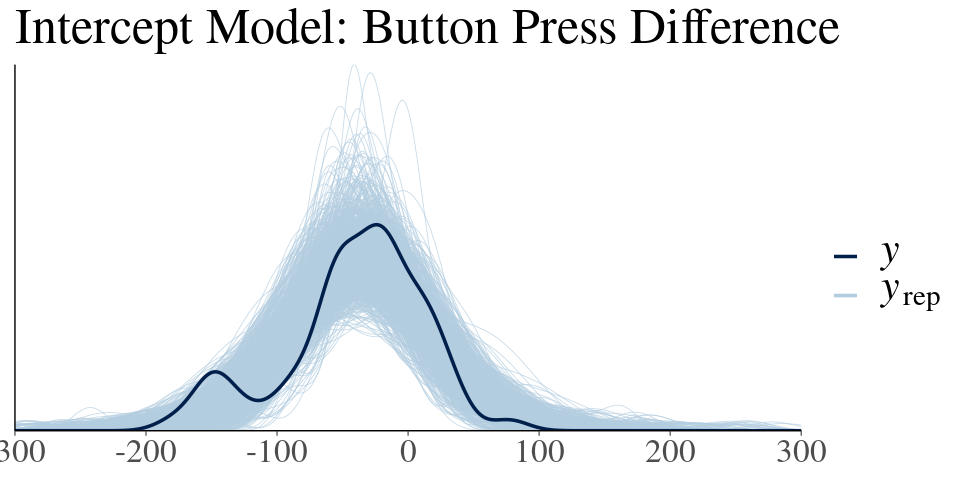

In [116]:
pp_plot = pp_check(fm,nsamples = 1000)

pp_plot + xlim(-300,300) + theme(text = element_text(size=25),legend.text=element_text(size=25)) + ggtitle("Intercept Model: Button Press Difference",)